<a href="https://colab.research.google.com/github/anosyrev/Skillbox-Convolutional-neural/blob/main/homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему мы сделали выбор в пользу VGGFace2?**

**ВПИШИТЕ ОТВЕТ ЗДЕСЬ**

Датасет VGGFace2 крупномасштабный набор данных содержащий огромное количество изображений персон, имеющие большие различия в позе, возрасте, освещении, этнической принадлежности и профессии (например, актеры, спортсмены, политики). Наш набор данных близок по содержанию к VGGFace2 и соответственно тот набор признаков, который был извлечен из датасета VGGFace2 пригодится нам для обучения нашей модели.

**-----**

*Возможный ответ: Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам горазддо полезне и помогут обучить модель лучше и быстрее*

**-----**




А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [ ]:
# Установка библиотек
! pip install gdown
! pip install git+https://github.com/rcmalli/keras-vggface.git
! pip install keras_applications --no-deps
! pip install livelossplot

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-yrsrh941
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-yrsrh941
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=e6155c51c44bbe89218936af000567032c78e91188de3159b1d67941c91e9ce1
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx01oq2r/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
# Импорт всех необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))


from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.models import load_model

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
import gdown

from collections import Counter
from livelossplot import PlotLossesKeras



Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [ ]:
vggface_model = VGGFace(model='resnet50') # or VGGFace() as default

165453824/165439116 [==============================] - 4s 0us/step


Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [ ]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2022-01-17 11:23:05--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.21.83.52, 172.67.214.206, 2606:4700:3035::ac43:d6ce, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.21.83.52|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2022-01-17 11:23:05--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.140.119, 104.21.87.37, 2606:4700:3031::6815:5725, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.140.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0s      

2022-01-17 11:23:05 (141 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1359872/1346516 [==============================] - 0s 0us/step


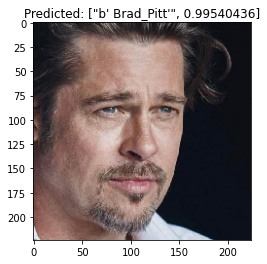

In [ ]:
img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:00<00:00, 227MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 67.3MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['38_1_0_20170104171708706.jpg.chip.jpg', '55_0_0_20170104205336259.jpg.chip.jpg', '1_1_2_20161219202727078.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,85_1_0_20170110182028892.jpg.chip.jpg,0.732759,0,1
1,50_0_3_20170119204347415.jpg.chip.jpg,0.431034,3,0
2,1_0_0_20161220220239129.jpg.chip.jpg,0.008621,0,0
3,28_1_1_20170112210934053.jpg.chip.jpg,0.241379,1,1
4,12_1_0_20170117181943783.jpg.chip.jpg,0.103448,0,1


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

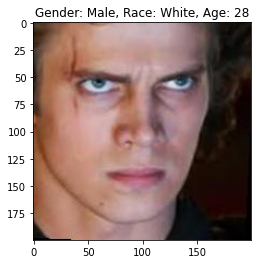

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


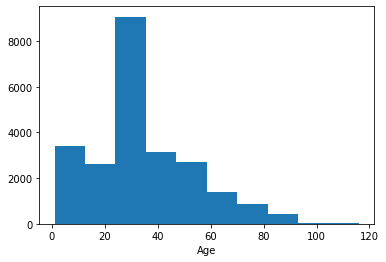

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]

print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

## Задание 2. Создание генератора данных для модели предсказания пола.
Предподготовка закончена. А теперь ваша очередь:) Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы предлагаем вам воспользоваться `tensorflow.keras.preprocessing.image.ImageDataGenerator`

###a) 
**Создайте генератор image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** Аугментацию использовать не нужно. 

Какой препроцессинг корректный? Как мы знаем, перед применением обученных сетей нужно знать какой препроцессинг они проводят с данными. Т.к. эта модель не часть Keras, мы должны ответить на этот вопрос сами с помощью исходников автора этой сети. К счастью, он приводит пример использования на главной странице репозитория. Видно, что он использует функцию preprocess_input из utils. Значит ей мы и должны воспользоваться!

In [ ]:
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    
    preprocessed = utils.preprocess_input(image_, version=2)
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

###b)

Для генерации картинок раньше мы использовали `image_gen.flow_from_folder`. Но для этого данные должны быть расположены на диске с определенной структурой папок, что в данном случае не очень удобно. Поэтому вы должны воспользоваться более гибким `image_gen.flow_from_dataframe`, который позволяет генерировать данные с нужными классами используя датафрейм (мы его создали выше для вас).

**Ознакомьтесь с документацией по [ссылке](https://keras.io/preprocessing/image/) (раздел flow_from_dataframe) и создайте train_generator и val_generator для df_train и df_val соответственно.**
*  Генератор должен возвращать картинку и ее класс (male/female)
*  class_mode укажите "binary", directory=str(data_folder)
*  batch_size, image_size указаны ниже
*  train_generator должен перемешивать данные, а val_generator -- не должен
*  После выполнения клетки ниже вы должны увидеть текст: *Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.*




In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 224

In [ ]:
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col='img_name',
    y_col='gender',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True)

val_generator = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col='img_name',
    y_col='gender',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False)

# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [ ]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


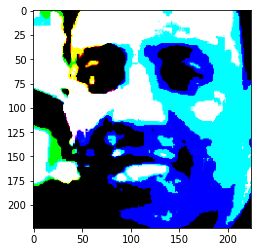

In [ ]:
plt.imshow(sample_images[70])
print(gender_mapping[int(sample_labels[70])])
# мы получим очень странное изображение и это нормально. 
# matplotlib ожидает картинку с интесивностями от 0 до 1 если она типа float и от 0 до 255 если int.

In [ ]:
print(sample_images[70].max(), sample_images[70].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

151.11731 -106.0912


###с)
**Реализуйте функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**
*  вам понадобится https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py
*  необходимо проделать операции preprocess_input в обратном порядке
*  наш случай: version=2, format="channels_last"

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    
    image = np.copy(vggface_image)
    #image = image[..., ::-1]
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1].astype(np.uint8) 
  
    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно
plt.imshow(deprocess_image(sample_images[70]))
print(gender_mapping[int(sample_labels[70])])

##Здание 3. Обучение модели предсказания пола

В этом задании вы должны обучить модель предсказания пола с точностью более 90% на валидационном сете. 

*   Возьмите за основу 'base_model' (определена ниже)
*   Вы должны сами решить сколько слоев замораживать и сколько полносвзяных слоев использовать. Рекомендуем начинать с модели с меньшим числом обучаемых параметров.
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_gender/checkpoint_best.h5"
*   Рекомендуется в model.fit(...) использовать steps_per_epoch=25, для того чтобы проверка на валидации происходила чаще и вы могли более точно отслеживать прогресс. Полная эпоха ~140 итераций.
*   За точность выше 94% -- дополнительные баллы.



In [ ]:
# для начала "отрежем" от vggface_model последний слой классификатора 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [ ]:
# < YOUR CODE STARTS HERE >
base_model.trainable = False
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(256, activation="sigmoid"),
                             tf.keras.layers.Dense(1, activation="sigmoid")
                             ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23561152  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,085,953
Trainable params: 524,801
Non-trainable params: 23,561,152
_________________________________________________________________


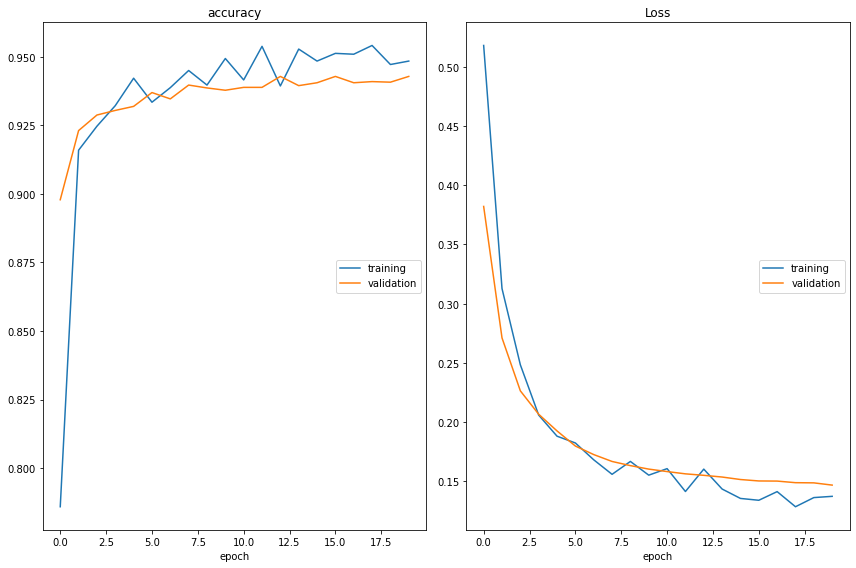

accuracy
	training         	 (min:    0.786, max:    0.954, cur:    0.948)
	validation       	 (min:    0.898, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.129, max:    0.518, cur:    0.137)
	validation       	 (min:    0.147, max:    0.382, cur:    0.147)

Epoch 00020: val_accuracy did not improve from 0.94285
25/25 [==============================] - 23s 920ms/step - loss: 0.1375 - accuracy: 0.9484 - val_loss: 0.1469 - val_accuracy: 0.9428


In [ ]:
#"model_gender/checkpoint_best.h5"
path = Path("model_gender")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model.fit(train_generator, epochs=20, validation_data=val_generator,
          callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=25)

In [ ]:
# Обучение модели предсказания пола

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
model_gender = load_model("model_gender/checkpoint_best.h5")
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 14s 352ms/step - loss: 0.1552 - accuracy: 0.9428
Well done!


In [ ]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

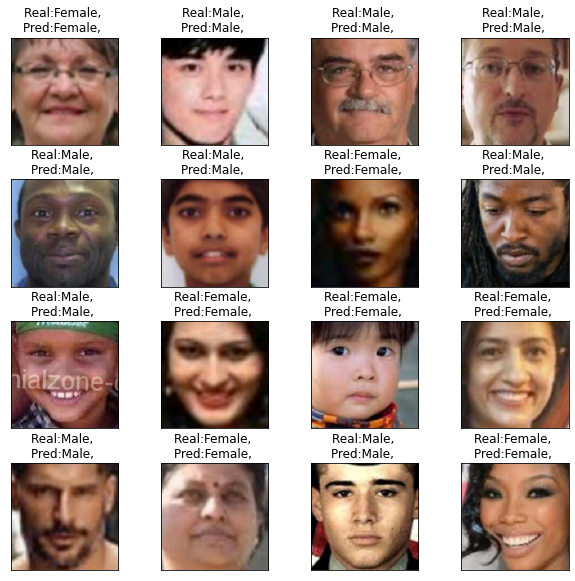

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Здание 4. Обучение модели предсказания расы

В этом задании вы должны обучить модель предсказания расы с точностью более 80% на валидационном сете. 

*   Используя код аналогичный тому, что выше, реализуйте модель предсказания расы
*   Для начала определите генератор данных
    *  нужно указать class_mode="sparse" и изменить "y_col"
*   Используйте чекпоинты, чтобы не потерять веса лучшей модели. Они должны быть сохранены с именем "model_race/checkpoint_best.h5"
*   За точность выше 85% -- дополнительные баллы.



In [ ]:
base_model.trainable = False
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

In [ ]:
# < YOUR CODE STARTS HERE >
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dense(256, activation="relu"),
                             tf.keras.layers.Dense(5, activation="sigmoid")
                             ])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23561152  
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                                                                 
 dense_23 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 24,086,981
Trainable params: 525,829
Non-trainable params: 23,561,152
_________________________________________________________________


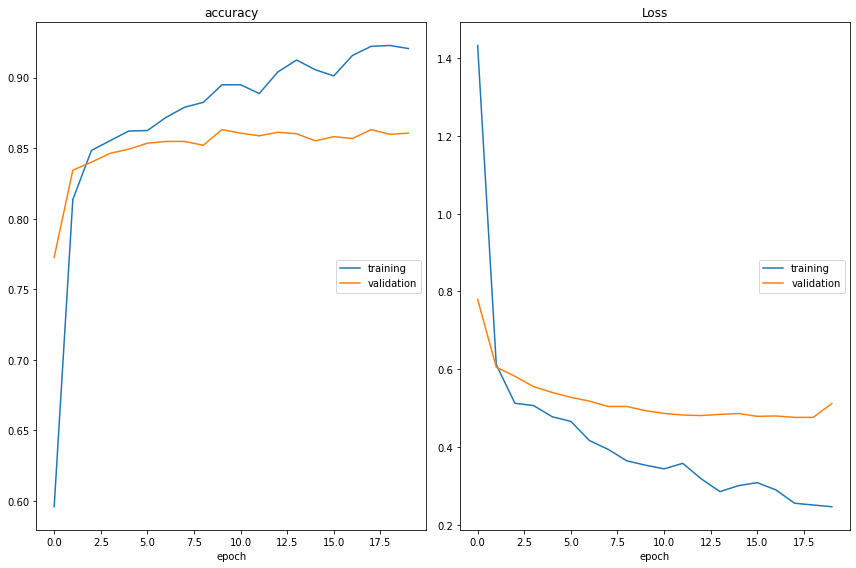

accuracy
	training         	 (min:    0.596, max:    0.923, cur:    0.921)
	validation       	 (min:    0.773, max:    0.863, cur:    0.861)
Loss
	training         	 (min:    0.246, max:    1.433, cur:    0.246)
	validation       	 (min:    0.476, max:    0.780, cur:    0.512)

Epoch 00020: val_accuracy did not improve from 0.86321
25/25 [==============================] - 22s 905ms/step - loss: 0.2463 - accuracy: 0.9206 - val_loss: 0.5118 - val_accuracy: 0.8607


In [ ]:
# Обучение модели предсказания расы
train_generator = image_gen.flow_from_dataframe(
    dataframe=df_train,
    directory=str(data_folder),
    x_col='img_name',
    y_col='race',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=True)

val_generator = image_gen.flow_from_dataframe(
    dataframe=df_val,
    directory=str(data_folder),
    x_col='img_name',
    y_col='race',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=BATCH_SIZE,
    shuffle=False)

#"model_race/checkpoint_best.h5"

path = Path("model_race")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model.fit(train_generator, epochs=20, validation_data=val_generator,
          callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=25)

In [ ]:
# < YOUR CODE ENDS HERE >

In [ ]:
model_race = load_model("model_race/checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 15s 358ms/step - loss: 0.4935 - accuracy: 0.8632
Well done!


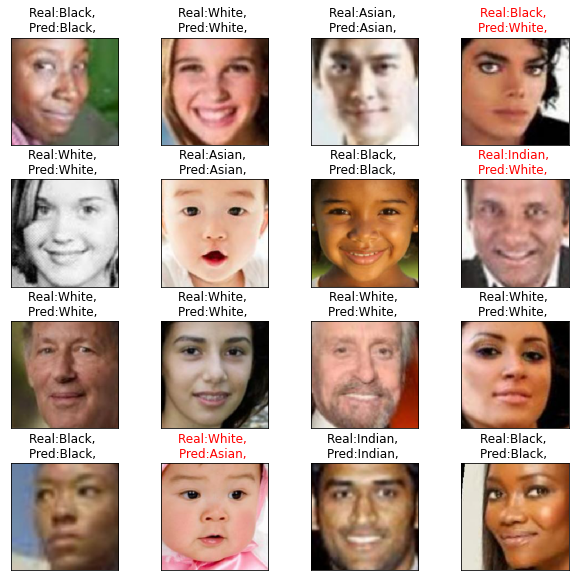

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [ ]:
vggface_model = VGGFace(model='resnet50')
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [ ]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_7").output)
base_model.trainable = False
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                           

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2048)         23561152    ['input_23[0][0]']               
                                                                                                  
 generalizing_layer (Dense)     (None, 256)          524544      ['model_1[14][0]']               
                                                                                                  
 gender_layer_in (Dense)        (None, 256)          65792       ['generalizing_layer[0][0]

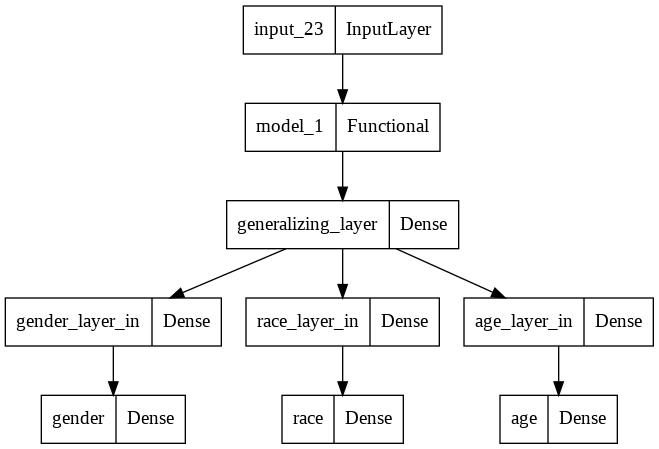

In [ ]:
#При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# < YOUR CODE STARTS HERE >
# переменная model должна содержать модель для дальнейшего обучения

base_model_outputs = base_model(input_layer)
generalizing_dense_layer = Dense(256, activation="sigmoid", name="generalizing_layer")(base_model_outputs)

gender_layer_in = Dense(256, activation="sigmoid", name="gender_layer_in")(generalizing_dense_layer)
gender_layer_out = Dense(1, activation="sigmoid", name="gender")(gender_layer_in)

race_layer_in = Dense(256, activation="relu", name="race_layer_in")(generalizing_dense_layer)
race_layer_out = Dense(5, activation="sigmoid", name="race")(race_layer_in)

age_layer_in = Dense(256, activation="relu", name="age_layer_in")(generalizing_dense_layer)
age_layer_out = Dense(1, activation="sigmoid", name="age")(age_layer_in)

model = tf.keras.Model(inputs=input_layer, outputs=[gender_layer_out, race_layer_out, age_layer_out])

# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model)


In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype("float32"), 3, axis=1)
        labels = [labels[0].reshape((len(labels[0]),)),
                  labels[1].reshape((len(labels[1]),)),
                  labels[2].reshape((len(labels[2]),))
                  ] 
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


А теперь перейдем к обучению:

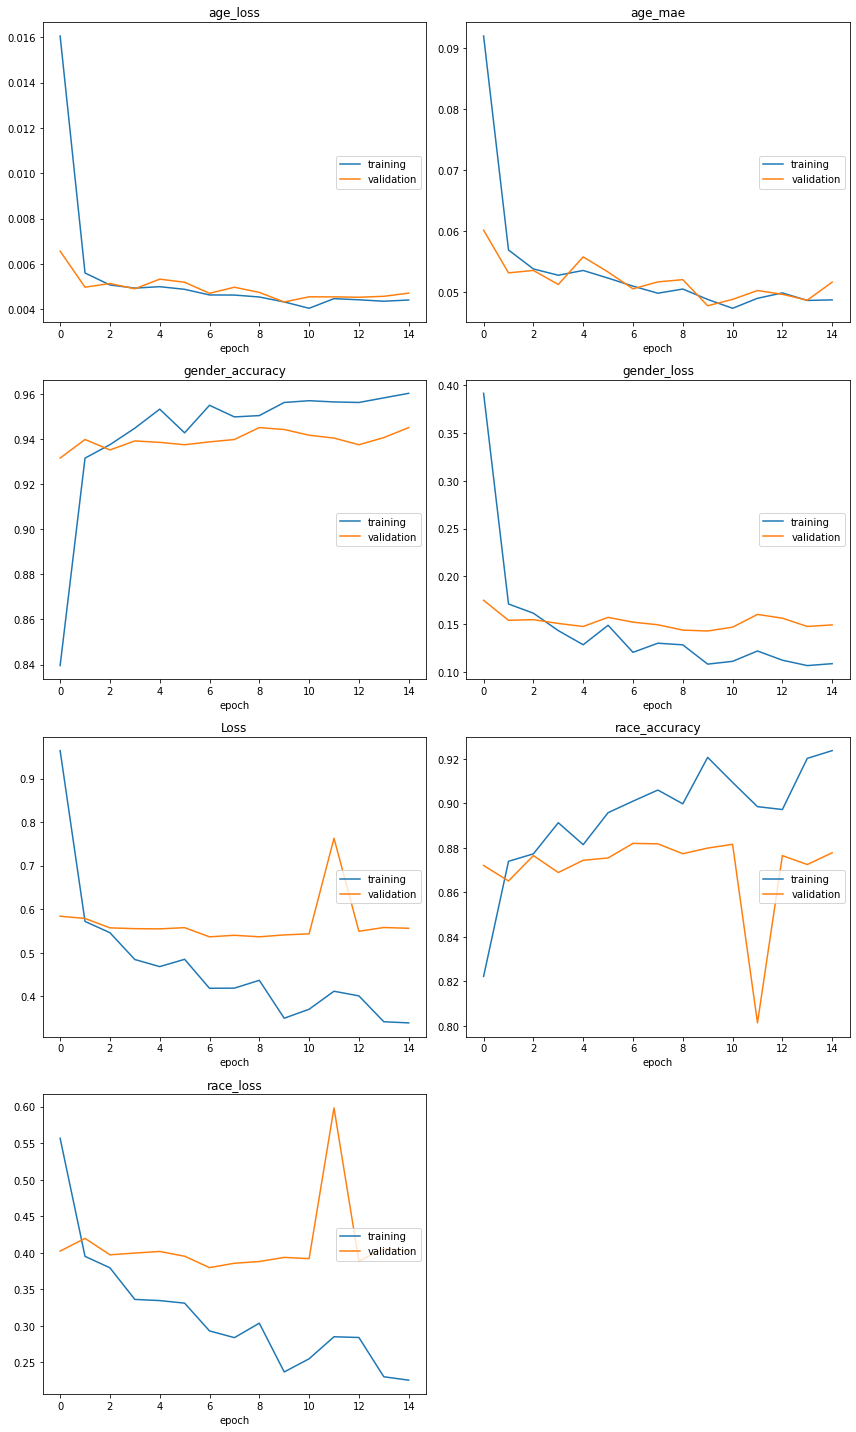

age_loss
	training         	 (min:    0.004, max:    0.016, cur:    0.004)
	validation       	 (min:    0.004, max:    0.007, cur:    0.005)
age_mae
	training         	 (min:    0.047, max:    0.092, cur:    0.049)
	validation       	 (min:    0.048, max:    0.060, cur:    0.052)
gender_accuracy
	training         	 (min:    0.840, max:    0.960, cur:    0.960)
	validation       	 (min:    0.932, max:    0.945, cur:    0.945)
gender_loss
	training         	 (min:    0.107, max:    0.392, cur:    0.109)
	validation       	 (min:    0.143, max:    0.175, cur:    0.149)
Loss
	training         	 (min:    0.339, max:    0.964, cur:    0.339)
	validation       	 (min:    0.536, max:    0.763, cur:    0.556)
race_accuracy
	training         	 (min:    0.822, max:    0.924, cur:    0.924)
	validation       	 (min:    0.801, max:    0.882, cur:    0.878)
race_loss
	training         	 (min:    0.226, max:    0.557, cur:    0.226)
	validation       	 (min:    0.380, max:    0.598, cur:    0.402)

E

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

model.fit(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [ ]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 33s 879ms/step - loss: 0.5557 - gender_loss: 0.1489 - race_loss: 0.4020 - age_loss: 0.0047 - gender_accuracy: 0.9451 - race_accuracy: 0.8780 - age_mae: 0.0517
Well done!


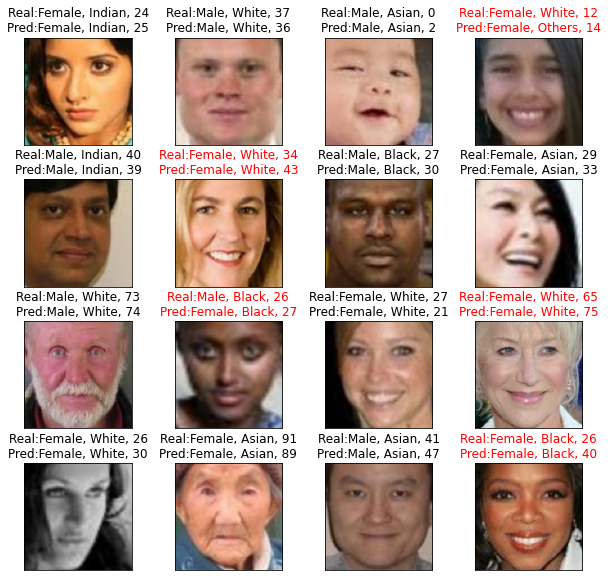

In [ ]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

Downloading...
From: https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-
To: /content/me.jpg
100%|██████████| 2.34M/2.34M [00:00<00:00, 123MB/s]


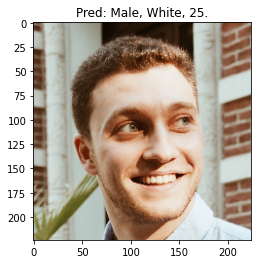

In [ ]:
url = 'https://drive.google.com/uc?id=1ZZgwwVxSjWG6gJT2uV2vt54QsLJcU07-'
output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)


#Заключение 

Это было очень сложное и важное домашнее задание. Надеемся, вы с ним справились успешно и готовы к переходу к следующему модулю! Удачи!